In [1]:
import sys
sys.path.append("../../../")

In [2]:
import numpy as np
from scipy.constants import m_p, c, e

In [3]:
from PyHEADTAIL.particles.particles import Particles
import PyHEADTAIL.particles.generators as generators
from PyHEADTAIL.trackers.transverse_tracking import TransverseMap
from PyHEADTAIL.trackers.simple_long_tracking import RFSystems, LinearMap
import PyHEADTAIL.cobra_functions.stats as st

PyHEADTAIL v1.4.2-41-g315651a735-dirty




In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

In [5]:
# general simulation parameters
n_turns = 20000
n_particles = 10000
n_segments = 1

# machine parameters
circumference = 157.
inj_alpha_x = 0#-1.2
inj_alpha_y = 0#15
inj_beta_x = 5.#5.9 # in [m]
inj_beta_y = 31.#5.7 # in [m]
Qx = 5.1
Qy = 6.1
gamma_tr = 4.05
alpha_c_array = [gamma_tr**-2]
V_rf = 8e3 # in [V]
harmonic = 1
phi_offset = 0 # measured from aligned focussing phase (0 or pi)
pipe_radius = 5e-2

# beam parameters
Ekin = 1.4e9 # in [eV]
intensity = 1.684e12
epsn_x = 2.5e-6 # in [m*rad]
epsn_y = 2.5e-6 # in [m*rad]
epsn_z = 1.2 # 4pi*sig_z*sig_dp (*p0/e) in [eVs]

# calculations
gamma = 1 + e * Ekin / (m_p * c**2)
beta = np.sqrt(1 - gamma**-2)
print('beta: ' + str(beta))
eta = alpha_c_array[0] - gamma**-2
print('eta: ' + str(eta))
if eta < 0:
    phi_offset = np.pi - phi_offset
Etot = gamma * m_p * c**2 / e
p0 = np.sqrt(gamma**2 - 1) * m_p * c
Qs = np.sqrt(np.abs(eta) * V_rf / (2 * np.pi * beta**2 * Etot))
print('Qs: ' + str(Qs))
beta_z = np.abs(eta) * circumference / (2 * np.pi * Qs)
print('beta_z: ' + str(beta_z))
turn_period = circumference / (beta * c)

# BETATRON
# Loop on number of segments and create the TransverseSegmentMap
# for each segment.
s = np.arange(0, n_segments + 1) * circumference / n_segments
alpha_x = inj_alpha_x * np.ones(n_segments)
beta_x  = inj_beta_x * np.ones(n_segments)
D_x     = np.zeros(n_segments)
alpha_y = inj_alpha_y * np.ones(n_segments)
beta_y  = inj_beta_y * np.ones(n_segments)
D_y     = np.zeros(n_segments)

beta: 0.915961012299
eta: -0.100049107837
Qs: 0.000254822142096
beta_z: 9810.60617229


In [6]:
def plot_phase_space(bunch):
    fig, (ax0, ax1, ax2) = plt.subplots(3, 1)
    # phase spaces
    ax0.scatter(bunch.x, bunch.xp)
    ax1.scatter(bunch.y, bunch.yp)
    ax2.scatter(bunch.z, bunch.dp)
    # statistical quantities
    ax0.scatter(bunch.mean_x(), bunch.mean_xp(), color='red')
    ax1.scatter(bunch.mean_y(), bunch.mean_yp(), color='red')
    ax2.scatter(bunch.mean_z(), bunch.mean_dp(), color='red')
    plt.show()

1.09520838516e-06
1.09520838516e-06
0.0133665725141


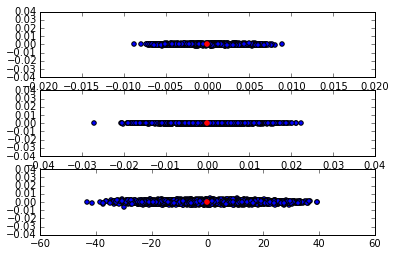

emittance x new: 2.45182772349e-06
emittance y new: 2.51484116678e-06


emittance z new: 1.19483239906


In [7]:
np.random.seed(0)
egeox = epsn_x/(beta*gamma)
egeoy = epsn_y/(beta*gamma)
egeoz = epsn_z*e/(4*np.pi*p0)
print(egeox)
print(egeoy)
print(egeoz)
bunch_new = generators.ParticleGenerator(macroparticlenumber=n_particles,
                 intensity=intensity, charge=e, mass=m_p,
                 circumference=circumference, gamma=gamma,
                 distribution_x=generators.gaussian2D(egeox), alpha_x=inj_alpha_x, beta_x=inj_beta_x,
                 distribution_y=generators.gaussian2D(egeoy), alpha_y=inj_alpha_y, beta_y=inj_beta_y,
                 distribution_z=generators.gaussian2D(egeoz), Qs=Qs, eta=eta).generate()
                                         #generators.transverse_linear_matcher(1., beta_z)).generate()
plot_phase_space(bunch_new)

print('emittance x new: '+ str(bunch_new.epsn_x()))
print('emittance y new: '+ str(bunch_new.epsn_y()))

#print('beta x: '+ str(bunch.beta_Twiss_x()))
#print('beta x new: '+ str(bunch_new.beta_Twiss_x()))
#print('beta y: '+ str(bunch.beta_Twiss_y()))
#print('beta y new: '+ str(bunch_new.beta_Twiss_y()))

#print('alpha x new: '+ str(bunch_new.alpha_Twiss_x()))
#print('alpha y new: '+ str(bunch_new.alpha_Twiss_y()))


#longitudinal stuff
print('\n')
print('emittance z new: '+ str(bunch_new.epsn_z()))
#print('beta_z via cf: ' + str(st.get_beta(bunch.z, bunch.dp, None)))
#print('beta_z new via cf: ' + str(st.get_beta(bunch_new.z, bunch_new.dp, None)))
#print('alpha_z via cf: ' + str(st.get_alpha(bunch.z, bunch.dp, None)))
#print('alpha_z new via cf: ' + str(st.get_alpha(bunch_new.z, bunch_new.dp, None)))


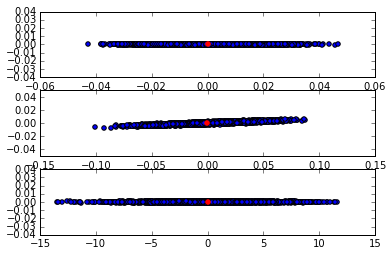

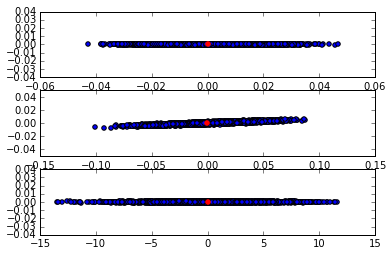

In [8]:
#check the convenience functions. when setting the seed, they should be exactly the same
np.random.seed(1)
bunch1 = generators.generate_Gaussian6DTwiss(n_particles, intensity,
        e, m_p, circumference, gamma,
        alpha_x=0.1, alpha_y = -1.9, beta_x=81.1, beta_y=31.2,
        beta_z=beta_z, epsn_x = 3.75e-6, epsn_y=4.2e-5, epsn_z=0.1,
        dispersion_x=1, dispersion_y=-2.5)
np.random.seed(1)
bunch2 = generators.ParticleGenerator(n_particles, intensity,
             e, m_p, circumference, gamma,
             distribution_x=generators.gaussian2D(3.75e-6/(gamma*beta)), alpha_x=0.1, beta_x=81.1, D_x=1,
             distribution_y=generators.gaussian2D(4.2e-5/(gamma*beta)), alpha_y=-1.9, beta_y=31.2, D_y=-2.5,
             distribution_z=generators.gaussian2D(0.1*e/(4*np.pi*p0)), Qs=Qs, eta=eta).generate()
plot_phase_space(bunch1)
plot_phase_space(bunch2)


In [9]:
#create a longitudinal only beam and track it, see if emittance grows ...
longitudinal = LinearMap(alpha_c_array, circumference, Qs)
for i in range(5):
    print('\n turn ' + str(i))
    print('emittance z new: '+ str(bunch_new.epsn_z()))
    #print('beta_z via cf: ' + str(st.get_beta(bunch.z, bunch.dp, None)))
    #print('beta_z new via cf: ' + str(st.get_beta(bunch_new.z, bunch_new.dp, None)))
    #print('alpha_z via cf: ' + str(st.get_alpha(bunch.z, bunch.dp, None)))
    #print('alpha_z new via cf: ' + str(st.get_alpha(bunch_new.z, bunch_new.dp, None)))
    longitudinal.track(bunch_new)
    print


 turn 0
emittance z new: 1.19483239906


 turn 1
emittance z new: 1.19483239906


 turn 2
emittance z new: 1.19483239906


 turn 3
emittance z new: 1.19483239906


 turn 4
emittance z new: 1.19483239906



In [10]:
# Gaussian6D

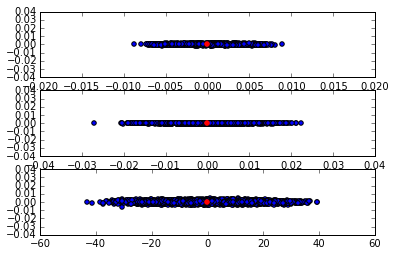

In [11]:
bunch_new = generators.ParticleGenerator(macroparticlenumber=n_particles,
                                     intensity=intensity, charge=e, mass=m_p,
                                     circumference=circumference, gamma=gamma,
                                     distribution_x=generators.import_distribution2D([bunch_new.x, bunch_new.xp]),
                                     distribution_y=generators.import_distribution2D([bunch_new.y, bunch_new.yp]),
                                     distribution_z=generators.import_distribution2D([bunch_new.z, bunch_new.dp])).generate()
plot_phase_space(bunch_new)     

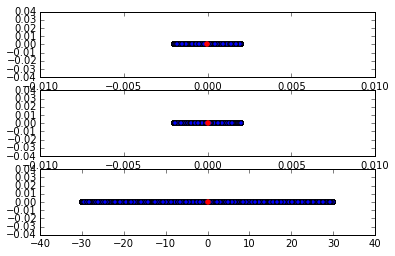

In [12]:

bunch_new = generators.ParticleGenerator(macroparticlenumber=n_particles,
                                     intensity=intensity, charge=e, mass=m_p,
                                     circumference=circumference, gamma=gamma,
                                     distribution_x=generators.uniform2D(-2e-3, 2e-3),
                                     distribution_y=generators.uniform2D(-2e-3, 2e-3),
                                     distribution_z=generators.uniform2D(-30, 30)).generate()
plot_phase_space(bunch_new)

In [13]:
transverse = TransverseMap(circumference, s, alpha_x, beta_x, D_x, alpha_y,
                           beta_y, D_y, Qx, Qy)
longitudinal = LinearMap(alpha_c_array, circumference, Qs)

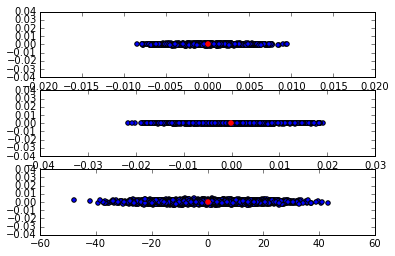

emittance x new: 2.48084958939e-06
emittance y new: 2.49411389698e-06


emittance z new: 1.17889201732


In [14]:
bunch_new = generators.ParticleGenerator(macroparticlenumber=n_particles,
                intensity=intensity, charge=e, mass=m_p,
                circumference=circumference, gamma=gamma,
                distribution_x=generators.gaussian2D(egeox), alpha_x=inj_alpha_x, beta_x=inj_beta_x,
                distribution_y=generators.gaussian2D(egeoy), alpha_y=inj_alpha_y, beta_y=inj_beta_y,
                distribution_z=generators.gaussian2D(egeoz), Qs=Qs, eta=eta).generate()
plot_phase_space(bunch_new)
print('emittance x new: '+ str(bunch_new.epsn_x()))
print('emittance y new: '+ str(bunch_new.epsn_y()))

#print('beta x: '+ str(bunch.beta_Twiss_x()))
#print('beta x new: '+ str(bunch_new.beta_Twiss_x()))
#print('beta y: '+ str(bunch.beta_Twiss_y()))
#print('beta y new: '+ str(bunch_new.beta_Twiss_y()))

#print('alpha x new: '+ str(bunch_new.alpha_Twiss_x()))
#print('alpha y new: '+ str(bunch_new.alpha_Twiss_y()))


#longitudinal stuff
print('\n')
print('emittance z new: '+ str(bunch_new.epsn_z()))

In [15]:
rfsystems = RFSystems(circumference, [harmonic], [V_rf], [phi_offset],
                      alpha_c_array, gamma)
rfsystems2 = RFSystems(circumference, [harmonic], [V_rf], [phi_offset],
                      alpha_c_array, gamma)

*** PyHEADTAIL WARNING! Are you trying RFSystems.get_bucket(gamma)? Either give a bunch to the first argument slot or use a keyword: get_bucket(gamma=gamma) . I'm helping you out for now with bunch = gamma.
*** Maximum RMS emittance 4.50589180434eV s.
... distance to target emittance: 7.72e-02
... distance to target emittance: 7.75e-02
... distance to target emittance: -4.08e-05
--> Emittance: 1.20000000151
--> Bunch length:11.8086653152


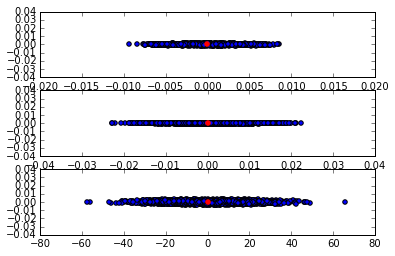

emittance x new: 2.50045343231e-06
emittance y new: 2.49566815534e-06


emittance z new: 1.22002599437


In [16]:
bunch_new = generators.ParticleGenerator(macroparticlenumber=n_particles,
                                     intensity=intensity, charge=e, mass=m_p,
                                     circumference=circumference, gamma=gamma,
                                     distribution_x=generators.gaussian2D(egeox), alpha_x=inj_alpha_x, beta_x=inj_beta_x,
                                     distribution_y=generators.gaussian2D(egeoy), alpha_y=inj_alpha_y, beta_y=inj_beta_y,
                                     distribution_z=generators.RF_bucket_distribution(rfsystems2.get_bucket(gamma),epsn_z=epsn_z),
                                     ).generate()

plot_phase_space(bunch_new)
print('emittance x new: '+ str(bunch_new.epsn_x()))
print('emittance y new: '+ str(bunch_new.epsn_y()))

#print('beta x: '+ str(bunch.beta_Twiss_x()))
#print('beta x new: '+ str(bunch_new.beta_Twiss_x()))
#print('beta y: '+ str(bunch.beta_Twiss_y()))
#print('beta y new: '+ str(bunch_new.beta_Twiss_y()))

#print('alpha x new: '+ str(bunch_new.alpha_Twiss_x()))
#print('alpha y new: '+ str(bunch_new.alpha_Twiss_y()))


#longitudinal stuff
print('\n')
print('emittance z new: '+ str(bunch_new.epsn_z()))

*** Maximum RMS emittance 4.50589180434eV s.
... distance to target emittance: 7.72e-02
... distance to target emittance: 7.75e-02
... distance to target emittance: -4.08e-05
--> Emittance: 1.20000000151
--> Bunch length:11.8086653152


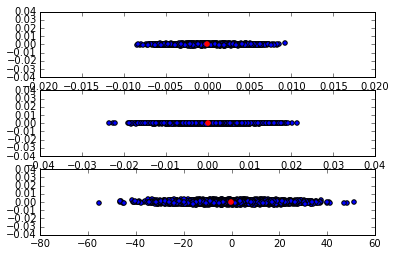

emittance x new: 2.49250875586e-06
emittance y new: 2.44590806196e-06


emittance z new: 1.20008899686


In [17]:
bunch_new = generators.ParticleGenerator(macroparticlenumber=n_particles,
                                     intensity=intensity, charge=e, mass=m_p,
                                     circumference=circumference, gamma=gamma,
                                     distribution_x=generators.gaussian2D(egeox), alpha_x=inj_alpha_x, beta_x=inj_beta_x,
                                     distribution_y=generators.gaussian2D(egeoy), alpha_y=inj_alpha_y, beta_y=inj_beta_y,
                                     distribution_z=generators.gaussian2D(egeoz), Qs=Qs, eta=eta).generate()



generators.ParticleGenerator(macroparticlenumber=n_particles,
                             intensity=intensity, charge=e, mass=m_p,
                             circumference=circumference, gamma=gamma,
                             distribution_z=generators.RF_bucket_distribution(rfsystems2.get_bucket(gamma=gamma),epsn_z=epsn_z),
                             ).update(bunch_new)

plot_phase_space(bunch_new)
print('emittance x new: '+ str(bunch_new.epsn_x()))
print('emittance y new: '+ str(bunch_new.epsn_y()))

#print('beta x: '+ str(bunch.beta_Twiss_x()))
#print('beta x new: '+ str(bunch_new.beta_Twiss_x()))
#print('beta y: '+ str(bunch.beta_Twiss_y()))
#print('beta y new: '+ str(bunch_new.beta_Twiss_y()))

#print('alpha x new: '+ str(bunch_new.alpha_Twiss_x()))
#print('alpha y new: '+ str(bunch_new.alpha_Twiss_y()))


#longitudinal stuff
print('\n')
print('emittance z new: '+ str(bunch_new.epsn_z()))

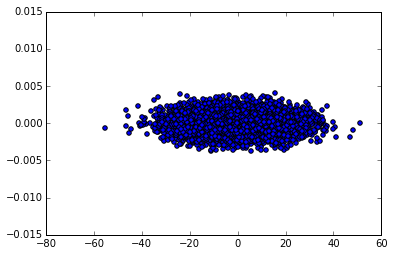

In [18]:
plt.scatter(bunch_new.z, bunch_new.dp)
plt.show()

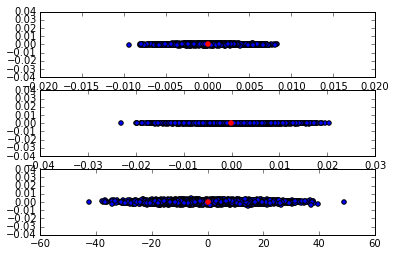

emittance x new: 2.54833932678e-06
emittance y new: 2.53080673199e-06


emittance z new: 1.21282466003


In [19]:
sigma_z = np.sqrt(beta_z * e * epsn_z / (4. * np.pi * p0))
sigma_dp = sigma_z / beta_z


bunch_new = generators.ParticleGenerator(
    macroparticlenumber=n_particles,
    intensity=intensity, charge=e, mass=m_p,
    circumference=circumference, gamma=gamma,
    distribution_x=generators.gaussian2D(egeox), alpha_x=inj_alpha_x, beta_x=inj_beta_x,
    distribution_y=generators.gaussian2D(egeoy), alpha_y=inj_alpha_y, beta_y=inj_beta_y,
    distribution_z=generators.cut_distribution(
                    generators.gaussian2D_asymmetrical(sigma_z, sigma_dp),
                    rfsystems.get_bucket(gamma=gamma).make_is_accepted(0.)),
).generate()

plot_phase_space(bunch_new)
print('emittance x new: '+ str(bunch_new.epsn_x()))
print('emittance y new: '+ str(bunch_new.epsn_y()))

#print('beta x: '+ str(bunch.beta_Twiss_x()))
#print('beta x new: '+ str(bunch_new.beta_Twiss_x()))
#print('beta y: '+ str(bunch.beta_Twiss_y()))
#print('beta y new: '+ str(bunch_new.beta_Twiss_y()))

#print('alpha x new: '+ str(bunch_new.alpha_Twiss_x()))
#print('alpha y new: '+ str(bunch_new.alpha_Twiss_y()))


#longitudinal stuff
print('\n')
print('emittance z new: '+ str(bunch_new.epsn_z()))

### testing margin in RFBucketMatcher

*** Maximum RMS emittance 4.50589180434eV s.
... distance to target emittance: 7.72e-02
... distance to target emittance: 7.75e-02
... distance to target emittance: -4.08e-05
--> Emittance: 1.20000000151
--> Bunch length:11.8086653152


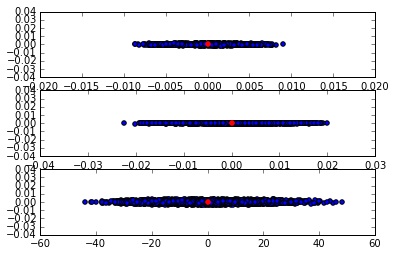

emittance x new: 2.47436980918e-06
emittance y new: 2.46850956903e-06


emittance z new: 1.18237329032


In [20]:
cutting_margin = 0.3
distz = generators.RF_bucket_distribution(
    rfsystems2.get_bucket(gamma=gamma), epsn_z=epsn_z, margin=cutting_margin)
bunch_new = generators.ParticleGenerator(
    macroparticlenumber=n_particles,
    intensity=intensity, charge=e, mass=m_p,
    circumference=circumference, gamma=gamma,
    distribution_x=generators.gaussian2D(egeox), alpha_x=inj_alpha_x, beta_x=inj_beta_x,
    distribution_y=generators.gaussian2D(egeoy), alpha_y=inj_alpha_y, beta_y=inj_beta_y,
    distribution_z=distz,
).generate()

plot_phase_space(bunch_new)
print('emittance x new: '+ str(bunch_new.epsn_x()))
print('emittance y new: '+ str(bunch_new.epsn_y()))

#print('beta x: '+ str(bunch.beta_Twiss_x()))
#print('beta x new: '+ str(bunch_new.beta_Twiss_x()))
#print('beta y: '+ str(bunch.beta_Twiss_y()))
#print('beta y new: '+ str(bunch_new.beta_Twiss_y()))

#print('alpha x new: '+ str(bunch_new.alpha_Twiss_x()))
#print('alpha y new: '+ str(bunch_new.alpha_Twiss_y()))


#longitudinal stuff
print('\n')
print('emittance z new: '+ str(bunch_new.epsn_z()))

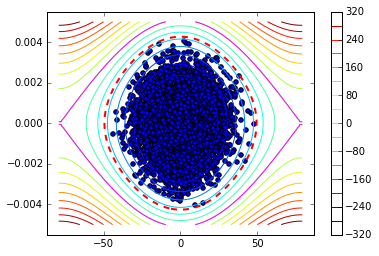

In [21]:
bucket = rfsystems2.get_bucket(gamma=gamma)
z = np.linspace(*bucket.interval, num=100)
dp = np.linspace(-0.005, 0.005, num=100)
ZZ, DPP = np.meshgrid(z, dp)
HH = bucket.hamiltonian(ZZ, DPP)
plt.contour(ZZ, DPP, HH, 20)
plt.colorbar()
plt.contour(ZZ, DPP, HH, levels=[0], colors='magenta')
plt.contour(ZZ, DPP, HH, levels=[bucket.h_sfp()*cutting_margin], colors='r', linewidths=2)
plt.scatter(bunch_new.z, bunch_new.dp)